# Jakub Kuczera Toxic Comments Classification

## Data Exploration

In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [9]:
data = pd.read_csv('toxiccomments.csv')

In [10]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


#### We check if all of values are unique and as we can see number of unique values is equal to number of rows in our dataset, so we have no duplicate comments

In [11]:
print(data.shape[0])
print(data['id'].nunique())

159571
159571


#### Function so we can easy add numbers on top of our bar charts

In [12]:
def addNumbers(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha='center')

In [13]:
data_temp = data.sum(axis = 1, numeric_only=True).value_counts()
number_of_classes = []
number_of_classes = [data[type_of_comment].value_counts()[1] for type_of_comment in data.columns[2:]]

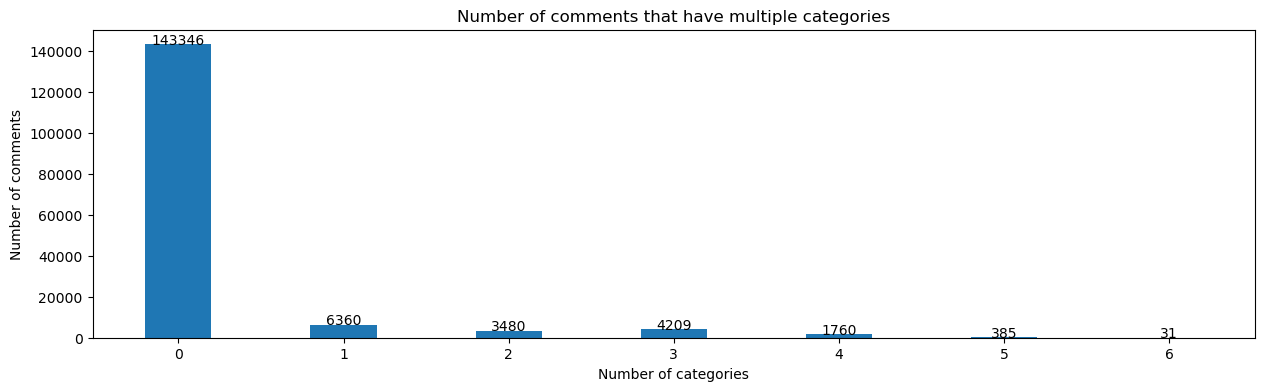

In [14]:
fig = plt.figure(figsize = (15,4))
plt.bar(data_temp.index, data_temp,  width = 0.4)
plt.xlabel("Number of categories")
plt.ylabel("Number of comments")
plt.title("Number of comments that have multiple categories")
addNumbers(data_temp.index, data_temp)
plt.show()

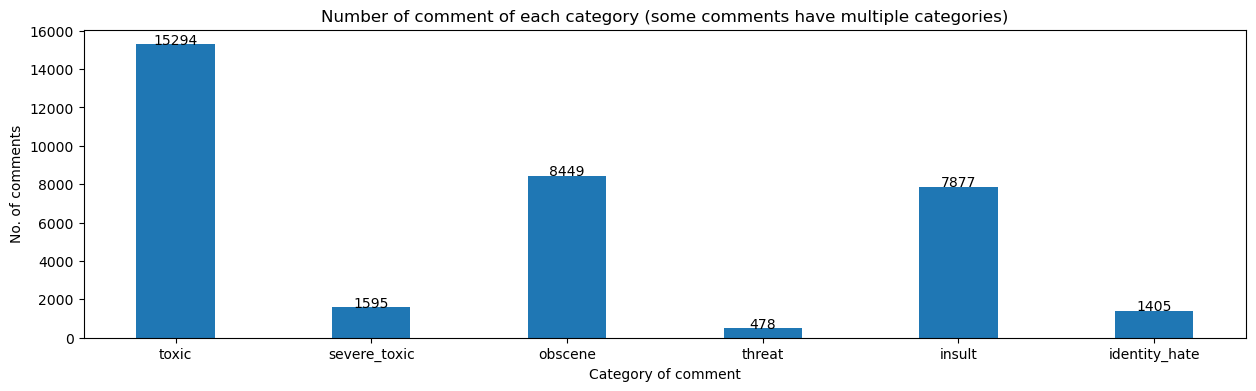

In [15]:
fig = plt.figure(figsize = (15,4))
plt.bar(data.columns[2:], number_of_classes,  width = 0.4)
plt.xlabel("Category of comment")
plt.ylabel("No. of comments")
plt.title("Number of comment of each category (some comments have multiple categories)")
addNumbers(data.columns[2:], number_of_classes)
plt.show()

#### As we can see, this dataset is very unbalanced. Most of comments are "positive" and only small part of "negative" comments are in categories like severe_toxic, threat or identity_hate

## Preparing And Preprocessing Data 

In [16]:
features = data['comment_text']
labels = data[data.columns[2:]].values

#### We create TextVectorization, max_tokens is number of words in our "dictionary". We choose 200000, which is 33% of all english words (according to google there is around 600000 words in english). Then we choose lenght of sequence and what type output will be

In [17]:
from tensorflow.keras.layers import TextVectorization
WORDS = 200000
tv = TextVectorization(max_tokens = WORDS, output_sequence_length=1000, output_mode='int')
tv.adapt(features.values)

#### Saving vectorizer, so when we rerun everything to test, we have our setup ready

In [23]:
pickle.dump({'config': tv.get_config(),'weights': tv.get_weights()}, open(r"models/tv_save.pkl", "wb"))

#### Spliting Data 

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33)

In [20]:
print(f'Size of Traning data: {len(X_train)}')
print(f'Size of Validation data: {len(X_val)}')
print(f'Size of Testing data: {len(X_test)}')

Size of Traning data: 127656
Size of Validation data: 21383
Size of Testing data: 10532


In [21]:
X_train = tv(X_train)
X_val = tv(X_val)
X_test = tv(X_test)

## Creating and Traning Neural Network Model

###### First layer of our model is Embedding layer. this layer maps input information from a high-dimensional to a lower-dimensional space, allowing the network to learn more about the relationship between inputs and to process the data more efficiently 
###### Then we will use LSTM layer with Bidirectional modifier, since in English certain words might change meaning of the sentance depending where we put them, it is important that our model will be able to pass values from LSTM Output across the board as we pass more sequances 
###### Then we use standard Dense layers, where last one has 6 units, since we are trying to predict 6 binary values (that's why we use BinaryCrossentropy) 

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

model = Sequential([
    Embedding(WORDS+1, 30),
    Bidirectional(LSTM(32, activation='tanh')),
    Dense(256,activation='relu'),
    Dense(512,activation='relu'),
    Dense(256,activation='relu'),
    Dense(6,activation='sigmoid'),
    ])

model.compile(optimizer='adam', loss = 'BinaryCrossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 30)          6000030   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16128     
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                        

#### Creating a callback that will save best model while training 

In [101]:
mc = tf.keras.callbacks.ModelCheckpoint(monitor='val_accuracy', mode='max',save_best_only=True, filepath = "best_model.h5", verbose = 1)

In [102]:
history = model.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_data=(X_val,y_val), callbacks = [mc])

Epoch 1/5
3990/3990 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9838
Epoch 1: val_accuracy improved from -inf to 0.99556, saving model to best_model.h5
3990/3990 [==============================] - 1290s 322ms/step - loss: 0.0635 - accuracy: 0.9838 - val_loss: 0.0496 - val_accuracy: 0.9956
Epoch 2/5
3990/3990 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9888
Epoch 2: val_accuracy did not improve from 0.99556
3990/3990 [==============================] - 1755s 440ms/step - loss: 0.0442 - accuracy: 0.9888 - val_loss: 0.0474 - val_accuracy: 0.9956
Epoch 3/5
3990/3990 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9939
Epoch 3: val_accuracy did not improve from 0.99556
3990/3990 [==============================] - 1535s 385ms/step - loss: 0.0386 - accuracy: 0.9939 - val_loss: 0.0486 - val_accuracy: 0.9956
Epoch 4/5
3990/3990 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9889
Epoch 4: val_

#### Ploting learning curves. As we can see first model was the best so callback saved it so we don't need to train a model again. Also we can se that traning mode for longer time only improve it preformance of traning set, on validation set accuracy didn't improve

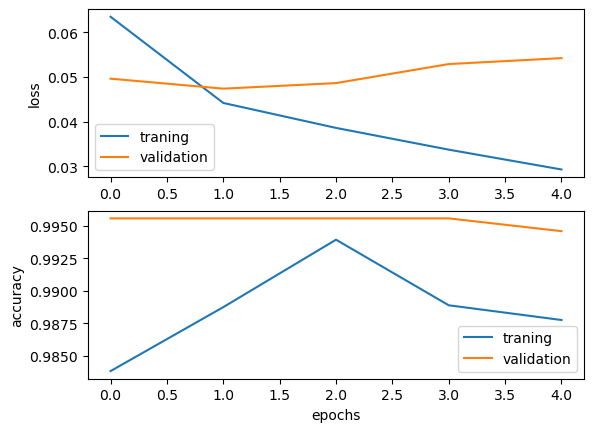

In [111]:
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['traning', 'validation'])
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['traning', 'validation'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

## Evaluation

In [24]:
model.load_weights(r'models/best_model.h5')

In [25]:
predictions = (model.predict(X_test) > 0.5).astype(int)

330/330 [==============================] - 21s 61ms/step


#### We can see that our model preforms well on testing set, but not perfect

In [26]:
from sklearn.metrics import precision_score,recall_score, f1_score
print(f'Metrics for the model: Precision {precision_score(y_test, predictions, average = "micro")}, Recall {recall_score(y_test, predictions, average = "micro")} , F1_Score {f1_score(y_test, predictions, average = "micro")}')

Metrics for the model: Precision 0.9154929577464789, Recall 0.5133830627468188 , F1_Score 0.6578577452909756


#### We load best model from training proccess and creating same vectorizer, then we can make prediction from user input without running everything

In [27]:
from tensorflow.keras.layers import TextVectorization
saved_vectorizer = pickle.load(open(r'models/tv_save.pkl', "rb"))
tv = TextVectorization.from_config(saved_vectorizer['config'])
tv.set_weights(saved_vectorizer['weights'])

#### Creating a function for user to test the model

In [28]:
def predict_user_input(comment):
    comment = tv(comment)
    prediction = (model.predict(np.expand_dims(comment,0)) > 0.5).astype(int)
    return prediction

In [29]:
comment = 'i hate that i love you'
print(list(predict_user_input(comment)))
print(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

1/1 [==============================] - 0s 54ms/step
[array([0, 0, 0, 0, 0, 0])]
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


#### As we can see model works pretty well, only problems that i was able to catch, are with classification if comments are threats, identity_hate or sometimes severe_toxic. It is because for example in case of threats we don't have much much comments in this category, so our model will not catch them right all the time. To fix this issues we would need more balanced dataset and train model maybe for longer.